This will plot and compare the resulting data. To run this, make sure that you have already generated all data you want to be compared. For instructions on how to run the generation, see README-new.md

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

from cloudmesh.common.Shell import Shell
from cloudmesh.common.parameter import Parameter
from cloudmesh.common.dotdict import dotdict

from cloudmesh.common.util import banner
from analysis import get_data, read_log, generate_df
pd.options.mode.chained_assignment = None 


In [2]:
# sizes = [100,1000,5000,10000,50000,100000,500000,1000000,5000000,10000000]

In [3]:
df = generate_df()

In [4]:
df

,p,size,repeat,sort,user,node,t,c,time
0,21,5000000,10,mp,alex,v100,None,None,10.880
1,21,5000000,10,mp,alex,v100,None,None,10.459
2,21,5000000,10,mp,alex,v100,None,None,10.650
3,21,5000000,10,mp,alex,v100,None,None,10.412
4,21,5000000,10,mp,alex,v100,None,None,10.265
...,...,...,...,...,...,...,...,...,...
3345,8,500000,10,mpi,alex,v100,None,None,3.687
3346,8,500000,10,mpi,alex,v100,None,None,3.576
3347,8,500000,10,mpi,alex,v100,None,None,3.722
3348,8,500000,10,mpi,alex,v100,None,None,3.710


In [5]:
def average_df(df):
    _df = df.groupby(['p','size','repeat','sort','user','node','t','c'], sort=True, as_index=False).agg({'time':'mean'})
    _df.reset_index()
    return _df

In [6]:
index_max_size = df[(df['size'] == 50000000) | (df['size'] == 500)].index
df.drop(index_max_size, inplace=True)

In [7]:
df = average_df(df)
print(df.to_string())

      p      size  repeat sort  user  node     t     c     time
0     1       100      10   mp  alex  v100  None  None   0.0150
1     1       100      10  seq  alex  v100  None  None   0.0006
2     1      1000      10   mp  alex  v100  None  None   0.0206
3     1      1000      10  seq  alex  v100  None  None   0.0055
4     1      5000      10   mp  alex  v100  None  None   0.0622
5     1      5000      10  seq  alex  v100  None  None   0.0269
6     1     10000      10   mp  alex  v100  None  None   0.0939
7     1     10000      10  seq  alex  v100  None  None   0.0563
8     1     50000      10   mp  alex  v100  None  None   0.3858
9     1     50000      10  seq  alex  v100  None  None   0.2859
10    1    100000      10   mp  alex  v100  None  None   0.7636
11    1    100000      10  seq  alex  v100  None  None   0.5455
12    1    500000      10   mp  alex  v100  None  None   3.4632
13    1    500000      10  seq  alex  v100  None  None   3.1286
14    1   1000000      10   mp  alex  v1

In [9]:
def calculate_speedup(df):
    frames = []
    gb = df.groupby(['size','repeat','user','node','t','c'])
    for x in gb.groups:
        _df = gb.get_group(x)
        seq_time = _df[_df['sort'] == 'seq'].iat[0, 8]
        # print(seq_time)
        scale = 1 / seq_time
        # print(scale)
        
        _df['speedup'] = _df['time'].rdiv(seq_time)
        frames.append(_df)
    ans = pd.concat(frames)
    return ans

In [8]:
def calculate_efficiency(df):
    ans = calculate_speedup(df)
    ans['efficiency'] = ans['speedup'] / ans['p']
    return ans

In [10]:
_df = calculate_efficiency(df)
_df

,p,size,repeat,sort,user,node,t,c,time,speedup,efficiency
0,1,100,10,mp,alex,v100,None,None,0.0150,0.040000,0.040000
1,1,100,10,seq,alex,v100,None,None,0.0006,1.000000,1.000000
28,2,100,10,mp,alex,v100,None,None,0.0227,0.026432,0.013216
29,2,100,10,mpi,alex,v100,None,None,2.8829,0.000208,0.000104
56,3,100,10,mp,alex,v100,None,None,0.0255,0.023529,0.007843
...,...,...,...,...,...,...,...,...,...,...,...
289,20,10000000,10,mp,alex,v100,None,None,21.1380,4.050080,0.202504
299,21,10000000,10,mp,alex,v100,None,None,20.7588,4.124063,0.196384
309,22,10000000,10,mp,alex,v100,None,None,20.4045,4.195673,0.190712
319,23,10000000,10,mp,alex,v100,None,None,19.9842,4.283914,0.186257


In [11]:
def plot_benchmark(df, x_axis, y_axis, hue, tag=None):
    hues = df[hue].unique()
    hues = [str(hue) for hue in hues]
    # name the image
    hues_name = "-".join(hues)
    name = f"{y_axis}-by-{x_axis}-{hue}"
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue)
    plt.title(name)
    plt.savefig(f"images/{name}.png")
    plt.savefig(f"images/{name}.pdf")

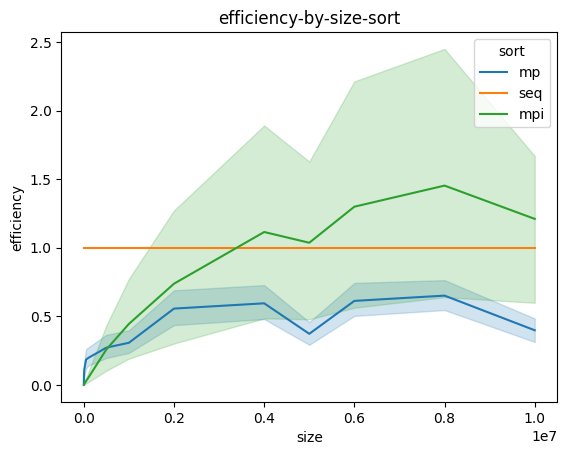

In [19]:
plot_benchmark(_df, 'size', 'time', 'sort')

In [32]:
def get_values(df, processes, sizes, sorts, users, nodes):
    _df = df[df['p'].isin(processes) & df['size'].isin(sizes) & df['sort'].isin(sorts) & df['user'].isin(users) & df['node'].isin(nodes)]
    return _df

In [33]:
df = get_values(df, [1, 2, 3], [50], ["mp", "mpi", "seq"], ["alex"], ["v100"])
df

,p,size,repeat,sort,user,node,t,c,time
0,1,50,10,mp,alex,v100,None,None,0.0251
1,1,50,10,mpi,alex,v100,None,None,0.9253
2,1,50,10,seq,alex,v100,None,None,0.0000
5,2,50,10,mp,alex,v100,None,None,0.0181
7,3,50,10,mp,alex,v100,None,None,0.0208


In [10]:
_df

,p,size,repeat,sort,user,node,t,c,time
10,2,50,10,mp,alex,v100,None,None,0.028
11,2,50,10,mp,alex,v100,None,None,0.017
12,2,50,10,mp,alex,v100,None,None,0.017
13,2,50,10,mp,alex,v100,None,None,0.016
14,2,50,10,mp,alex,v100,None,None,0.018
15,2,50,10,mp,alex,v100,None,None,0.016
16,2,50,10,mp,alex,v100,None,None,0.017
17,2,50,10,mp,alex,v100,None,None,0.017
18,2,50,10,mp,alex,v100,None,None,0.017
19,2,50,10,mp,alex,v100,None,None,0.018


In [ ]:
def plot_benchmark_by_size(df, size=None, tag=None, files=None, x="sizes", y="time"):
    names = "-".join(files)
    sns.lineplot(data=df, x=x, y=y, hue="name");
    t = tag.title()
    label = f"{t}".replace("_", " ")
    plt.title(f"{label}")
    if "time" in y: y = f"{y}/s"
    if "time" in x: x = f"{x}/s"
    plt.xlabel(x.capitalize())
    plt.ylabel(y.capitalize())
    plt.savefig(f"images/{tag}-{names}.png")
    plt.savefig(f"images/{tag}-{names}.pdf")

In [ ]:
def plot()

In [ ]:
df

In [ ]:
df = df.pivot_table(
    values='time', index=['tag', 'processes'], columns=['name', 'size'], fill_value=0, aggfunc='mean')

In [ ]:
df

In [11]:
print(df.loc['mp-mergesort'])
speedup = df.rdiv(df.loc['seq-merge'].iloc[0])
speedup

KeyError: 'mp-mergesort'